# Table of Contents

* [Import Packages](#Packages)
* [Left Globus Pallidus Segmentation](#left_globus_pallidus)
* [Right Globus Pallidus Segmentation](#right_globus_pallidus)
* [Whole Brain Segmentation](#whole_brain)
* [Averaging Left and Right Globus Pallidus Values](#Pixels_in_gp)

<a class="anchor" id="Packages"></a>

In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Packages for image segmentation 
%matplotlib ipympl
import ipywidgets as widgets
import urllib
import matplotlib.cbook as cbook
from mpl_interactions import image_segmenter
import PIL

<a class="anchor" id="Brain"></a>

# Import sample

Below we import a brain and show one ion that lights up the brain very well - 327.2329. We assume the sample .txt file has been placed in the same directory as the notebook.

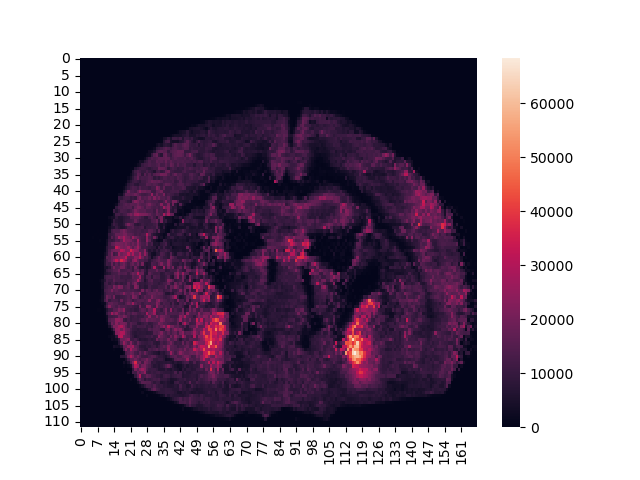

In [2]:
num_metabolites_negative = 13
# Import metabolomics matrix only
metabolomics_matrix_225_a1wt = pd.read_csv('225_a1wt_subsampled.txt', sep = '\t', usecols = [i for i in range(3, num_metabolites_negative+3)], header = 2)
# Drop retention time
metabolomics_matrix_225_a1wt = metabolomics_matrix_225_a1wt.drop(0)
# Reset index to start with 0
metabolomics_matrix_225_a1wt = metabolomics_matrix_225_a1wt.reset_index(drop = True)
# Read in coordinates for metabolomics matrix
coordinates_matrix_225_a1wt = pd.read_csv('225_a1wt_subsampled.txt', sep = '\t', usecols = [i for i in range(1,3)], skiprows = 4, names = ['x_coord', 'y_coord'])
# Below we plot the ion 303.2328 (the second ion in the list)
uniform_data_225_a1wt = np.array(metabolomics_matrix_225_a1wt).T.reshape([num_metabolites_negative, len(coordinates_matrix_225_a1wt[coordinates_matrix_225_a1wt['x_coord'] == coordinates_matrix_225_a1wt.iloc[0][0]]), len(coordinates_matrix_225_a1wt[coordinates_matrix_225_a1wt['y_coord'] == coordinates_matrix_225_a1wt.iloc[0][1]])])[metabolomics_matrix_225_a1wt.columns.get_loc('327.2329')]
ax = sns.heatmap(uniform_data_225_a1wt)
plt.show()

<a class="anchor" id="left_globus_pallidus"></a>
Below we use the segmentation tool from the mpl_interactions package. This allows us to easily trace a region of interest of an image and even spits out the coordinates for the mask we want to use!

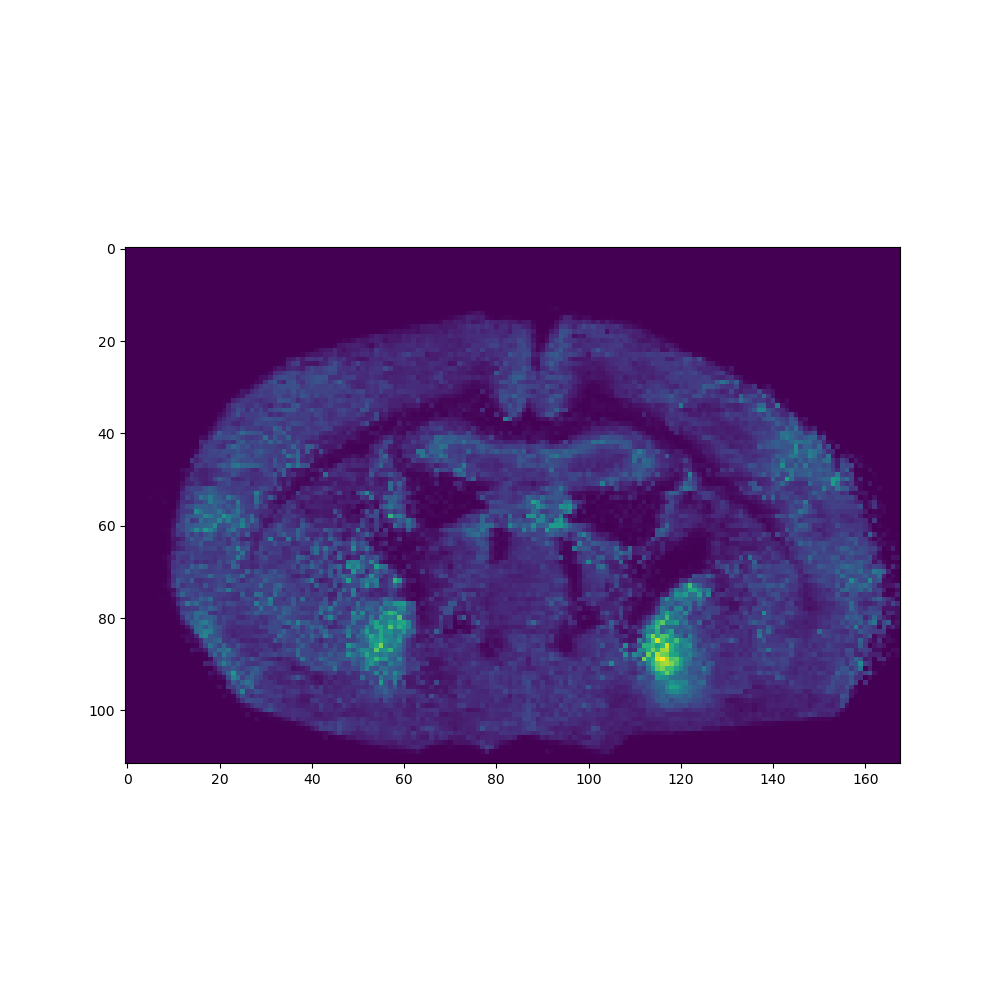

In [3]:
classes = ['Left Globus Pallidus']

# Define number of rois (here just 1 since we want the Left Globus Pallidus)
N_classes = 1
class_selector = widgets.Dropdown(options=classes, description="class")


def update(change):
    segmenter_225_a1wt_left_globus_pallidus.current_class = class_selector.value
    segmenter_225_a1wt_left_globus_pallidus.erasing = erasing_button.value


erasing_button = widgets.Checkbox(value=False, description="Erasing")
erasing_button.observe(update, names="value")

class_selector.observe(update, names="value")
# Define number of classes (rois) as N_classes set above
segmenter_225_a1wt_left_globus_pallidus = image_segmenter(uniform_data_225_a1wt, nclasses = N_classes, mask_alpha=0.76)
display(widgets.HBox([erasing_button, class_selector]))
display(segmenter_225_a1wt_left_globus_pallidus)

Below we set all background pixels to zero, and calculate the percentages of all ions within the brain and save these results.

In [4]:
# Make variable for mask
mask_225_a1wt_left_globus_pallidus = segmenter_225_a1wt_left_globus_pallidus.mask
# Create mask for pixels to tell where brain matter is
coordinates_roi_225_a1wt_left_globus_pallidus = pd.DataFrame(mask_225_a1wt_left_globus_pallidus.reshape(len(coordinates_matrix_225_a1wt)))
print('Number of pixels in mask:', len(coordinates_roi_225_a1wt_left_globus_pallidus[coordinates_roi_225_a1wt_left_globus_pallidus[0] == 1]))

# Make copy of metabolomics matrix to use as identifier of pixels for brain matter
metabolomics_matrix_225_a1wt_for_pixel_identities_left_globus_pallidus = metabolomics_matrix_225_a1wt.copy()
# Add segmentation labels to metabolomics matrix
metabolomics_matrix_225_a1wt_for_pixel_identities_left_globus_pallidus['roi'] = coordinates_roi_225_a1wt_left_globus_pallidus
# Specify the pixels are from the background
metabolomics_matrix_225_a1wt_for_pixel_identities_left_globus_pallidus.loc[metabolomics_matrix_225_a1wt_for_pixel_identities_left_globus_pallidus.roi == 0, :] = 0
# Drop identity column
metabolomics_matrix_225_a1wt_for_pixel_identities_left_globus_pallidus = metabolomics_matrix_225_a1wt_for_pixel_identities_left_globus_pallidus.drop(columns = 'roi')
# Save dataframe results
metabolomics_matrix_225_a1wt_for_pixel_identities_left_globus_pallidus.to_csv('225_a1wt_pixel_matrix_with_mask_left_globus_pallidus.csv')
# Find total number of pixels
metabolomics_matrix_225_a1wt_for_pixel_identities_left_globus_pallidus_pixel_count = len(metabolomics_matrix_225_a1wt_for_pixel_identities_left_globus_pallidus[metabolomics_matrix_225_a1wt_for_pixel_identities_left_globus_pallidus.sum(axis = 1) != 0])

# Find total ion current for pixel spectra
sum_by_pixel = metabolomics_matrix_225_a1wt_for_pixel_identities_left_globus_pallidus.sum(axis=1)
# Divide pixel values by pixel sum for all pixels
metabolomics_matrix_225_a1wt_for_pixel_identities_left_globus_pallidus_tic_normalized_pixel = metabolomics_matrix_225_a1wt_for_pixel_identities_left_globus_pallidus.divide(sum_by_pixel, axis=0)
# Sum values for ions
sums_of_ion_intensities_metabolomics_matrix_225_a1wt_for_pixel_identities_left_globus_pallidus_tic_normalized_pixel = metabolomics_matrix_225_a1wt_for_pixel_identities_left_globus_pallidus_tic_normalized_pixel.sum(axis = 0)
sums_of_ion_intensities_metabolomics_matrix_225_a1wt_for_pixel_identities_left_globus_pallidus_tic_normalized_pixel.to_csv('225_a1wt_sum_of_ions_within_left_globus_pallidus.csv')
# Divide by brain size to get normalized ion sums
sums_of_ion_intensities_metabolomics_matrix_225_a1wt_for_pixel_identities_left_globus_pallidus_tic_normalized_pixel_normalized_brain = sums_of_ion_intensities_metabolomics_matrix_225_a1wt_for_pixel_identities_left_globus_pallidus_tic_normalized_pixel/metabolomics_matrix_225_a1wt_for_pixel_identities_left_globus_pallidus_pixel_count
# Take sum of all values to get total ion count
total_sum_roi_normalized_225_a1wt_left_globus_pallidus = sums_of_ion_intensities_metabolomics_matrix_225_a1wt_for_pixel_identities_left_globus_pallidus_tic_normalized_pixel_normalized_brain.sum()
# Divide by total ion count and multiply by 100 to get final percentage
sums_of_ion_intensities_roi_percentage_normalized_225_a1wt_left_globus_pallidus = sums_of_ion_intensities_metabolomics_matrix_225_a1wt_for_pixel_identities_left_globus_pallidus_tic_normalized_pixel_normalized_brain/total_sum_roi_normalized_225_a1wt_left_globus_pallidus*100
sums_of_ion_intensities_roi_percentage_normalized_225_a1wt_left_globus_pallidus.to_csv('225_a1wt_percentage_of_ions_within_left_globus_pallidus.csv')

Number of pixels in mask: 266


<a class="anchor" id="right_globus_pallidus"></a>
Below we repeat for the right globus pallidus.

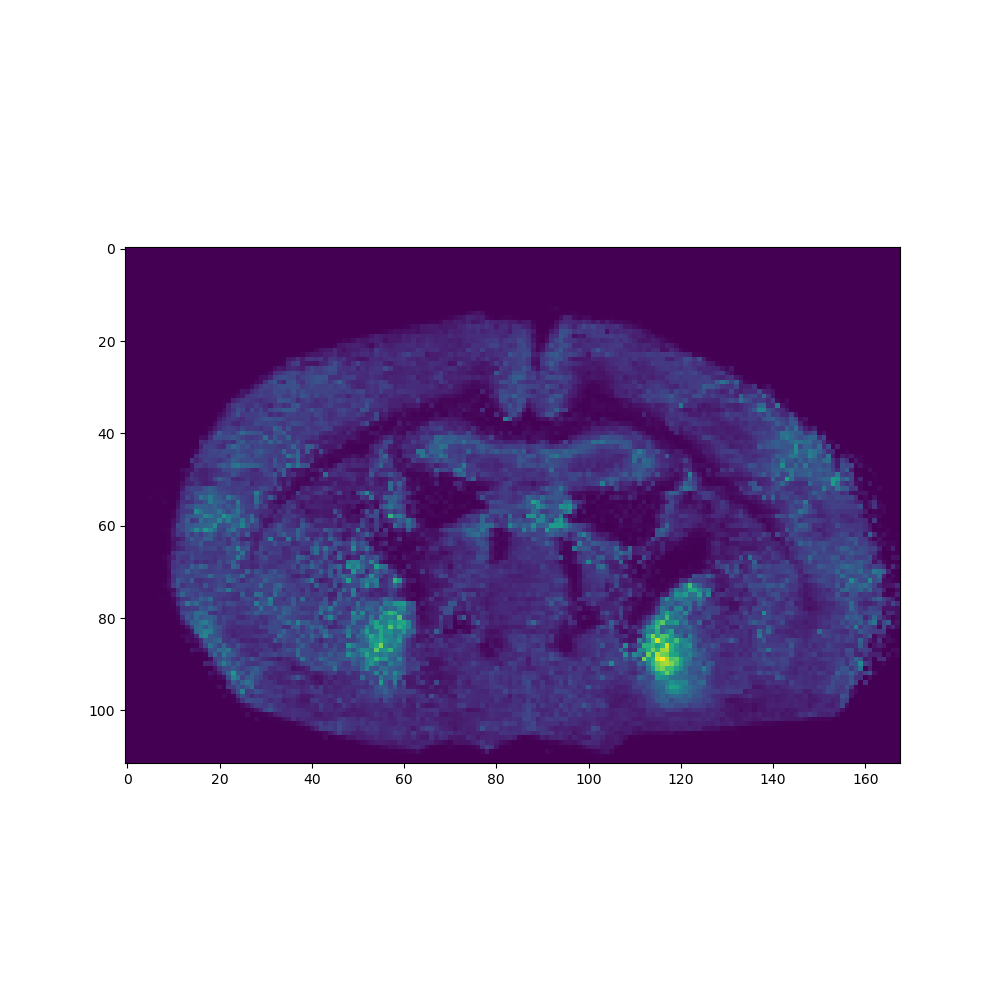

In [5]:
classes = ['Right Globus Pallidus']

# Define number of rois (here just 1 since we want the right Globus Pallidus)
N_classes = 1
class_selector = widgets.Dropdown(options=classes, description="class")


def update(change):
    segmenter_225_a1wt_right_globus_pallidus.current_class = class_selector.value
    segmenter_225_a1wt_right_globus_pallidus.erasing = erasing_button.value


erasing_button = widgets.Checkbox(value=False, description="Erasing")
erasing_button.observe(update, names="value")

class_selector.observe(update, names="value")
# Define number of classes (rois) as N_classes set above
segmenter_225_a1wt_right_globus_pallidus = image_segmenter(uniform_data_225_a1wt, nclasses = N_classes, mask_alpha=0.76)
display(widgets.HBox([erasing_button, class_selector]))
display(segmenter_225_a1wt_right_globus_pallidus)

Below we set all background pixels to zero, and calculate the percentages of all ions within the brain and save these results.

In [6]:
# Make variable for mask
mask_225_a1wt_right_globus_pallidus = segmenter_225_a1wt_right_globus_pallidus.mask
# Create mask for pixels to tell where brain matter is
coordinates_roi_225_a1wt_right_globus_pallidus = pd.DataFrame(mask_225_a1wt_right_globus_pallidus.reshape(len(coordinates_matrix_225_a1wt)))
print('Number of pixels in mask:', len(coordinates_roi_225_a1wt_right_globus_pallidus[coordinates_roi_225_a1wt_right_globus_pallidus[0] == 1]))

# Make copy of metabolomics matrix to use as identifier of pixels for brain matter
metabolomics_matrix_225_a1wt_for_pixel_identities_right_globus_pallidus = metabolomics_matrix_225_a1wt.copy()
# Add segmentation labels to metabolomics matrix
metabolomics_matrix_225_a1wt_for_pixel_identities_right_globus_pallidus['roi'] = coordinates_roi_225_a1wt_right_globus_pallidus
# Specify the pixels are from the background
metabolomics_matrix_225_a1wt_for_pixel_identities_right_globus_pallidus.loc[metabolomics_matrix_225_a1wt_for_pixel_identities_right_globus_pallidus.roi == 0, :] = 0
# Drop identity column
metabolomics_matrix_225_a1wt_for_pixel_identities_right_globus_pallidus = metabolomics_matrix_225_a1wt_for_pixel_identities_right_globus_pallidus.drop(columns = 'roi')
# Save dataframe results
metabolomics_matrix_225_a1wt_for_pixel_identities_right_globus_pallidus.to_csv('225_a1wt_pixel_matrix_with_mask_right_globus_pallidus.csv')
# Find total number of pixels
metabolomics_matrix_225_a1wt_for_pixel_identities_right_globus_pallidus_pixel_count = len(metabolomics_matrix_225_a1wt_for_pixel_identities_right_globus_pallidus[metabolomics_matrix_225_a1wt_for_pixel_identities_right_globus_pallidus.sum(axis = 1) != 0])

# Find total ion current for pixel spectra
sum_by_pixel = metabolomics_matrix_225_a1wt_for_pixel_identities_right_globus_pallidus.sum(axis=1)
# Divide pixel values by pixel sum for all pixels
metabolomics_matrix_225_a1wt_for_pixel_identities_right_globus_pallidus_tic_normalized_pixel = metabolomics_matrix_225_a1wt_for_pixel_identities_right_globus_pallidus.divide(sum_by_pixel, axis=0)
# Sum values for ions
sums_of_ion_intensities_metabolomics_matrix_225_a1wt_for_pixel_identities_right_globus_pallidus_tic_normalized_pixel = metabolomics_matrix_225_a1wt_for_pixel_identities_right_globus_pallidus_tic_normalized_pixel.sum(axis = 0)
sums_of_ion_intensities_metabolomics_matrix_225_a1wt_for_pixel_identities_right_globus_pallidus_tic_normalized_pixel.to_csv('225_a1wt_sum_of_ions_within_right_globus_pallidus.csv')
# Divide by brain size to get normalized ion sums
sums_of_ion_intensities_metabolomics_matrix_225_a1wt_for_pixel_identities_right_globus_pallidus_tic_normalized_pixel_normalized_brain = sums_of_ion_intensities_metabolomics_matrix_225_a1wt_for_pixel_identities_right_globus_pallidus_tic_normalized_pixel/metabolomics_matrix_225_a1wt_for_pixel_identities_right_globus_pallidus_pixel_count
# Take sum of all values to get total ion count
total_sum_roi_normalized_225_a1wt_right_globus_pallidus = sums_of_ion_intensities_metabolomics_matrix_225_a1wt_for_pixel_identities_right_globus_pallidus_tic_normalized_pixel_normalized_brain.sum()
# Divide by total ion count and multiply by 100 to get final percentage
sums_of_ion_intensities_roi_percentage_normalized_225_a1wt_right_globus_pallidus = sums_of_ion_intensities_metabolomics_matrix_225_a1wt_for_pixel_identities_right_globus_pallidus_tic_normalized_pixel_normalized_brain/total_sum_roi_normalized_225_a1wt_right_globus_pallidus*100
sums_of_ion_intensities_roi_percentage_normalized_225_a1wt_right_globus_pallidus.to_csv('225_a1wt_percentage_of_ions_within_right_globus_pallidus.csv')

Number of pixels in mask: 261


<a class="anchor" id="whole_brain"></a>
Below we repeat for the whole brain.

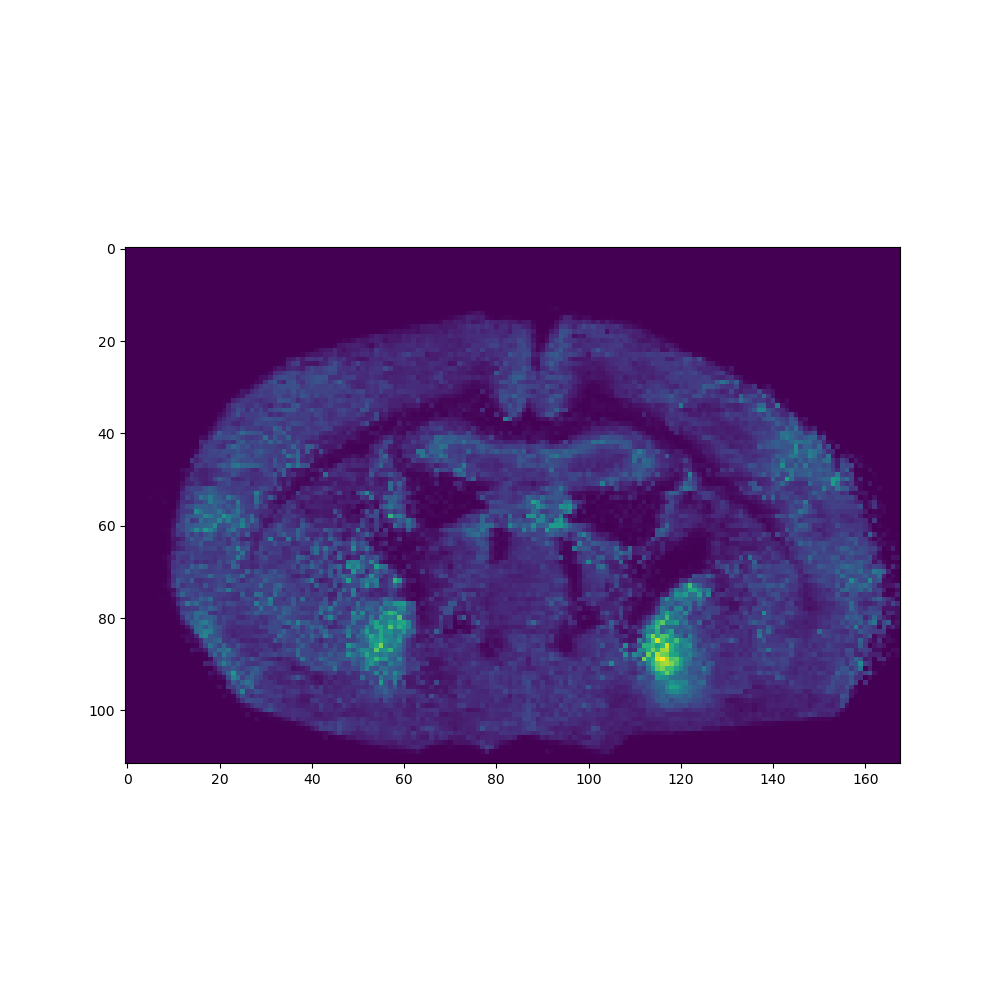

In [14]:
classes = ['Whole Brain']

# Define number of rois (here just 1 since we want the Left Globus Pallidus)
N_classes = 1
class_selector = widgets.Dropdown(options=classes, description="class")


def update(change):
    segmenter_225_a1wt_whole_brain.current_class = class_selector.value
    segmenter_225_a1wt_whole_brain.erasing = erasing_button.value


erasing_button = widgets.Checkbox(value=False, description="Erasing")
erasing_button.observe(update, names="value")

class_selector.observe(update, names="value")
# Define number of classes (rois) as N_classes set above
segmenter_225_a1wt_whole_brain = image_segmenter(uniform_data_225_a1wt, nclasses = N_classes, mask_alpha=0.76)
display(widgets.HBox([erasing_button, class_selector]))
display(segmenter_225_a1wt_whole_brain)

Below we set all background pixels to zero, and calculate the percentages of all ions within the brain and save these results.

In [15]:
# Make variable for mask
mask_225_a1wt_whole_brain = segmenter_225_a1wt_whole_brain.mask
# Create mask for pixels to tell where brain matter is
coordinates_roi_225_a1wt_whole_brain = pd.DataFrame(mask_225_a1wt_whole_brain.reshape(len(coordinates_matrix_225_a1wt)))
print('Number of pixels in mask:', len(coordinates_roi_225_a1wt_whole_brain[coordinates_roi_225_a1wt_whole_brain[0] == 1]))

# Make copy of metabolomics matrix to use as identifier of pixels for brain matter
metabolomics_matrix_225_a1wt_for_pixel_identities_whole_brain = metabolomics_matrix_225_a1wt.copy()
# Add segmentation labels to metabolomics matrix
metabolomics_matrix_225_a1wt_for_pixel_identities_whole_brain['roi'] = coordinates_roi_225_a1wt_whole_brain
# Specify the pixels are from the background
metabolomics_matrix_225_a1wt_for_pixel_identities_whole_brain.loc[metabolomics_matrix_225_a1wt_for_pixel_identities_whole_brain.roi == 0, :] = 0
# Drop identity column
metabolomics_matrix_225_a1wt_for_pixel_identities_whole_brain = metabolomics_matrix_225_a1wt_for_pixel_identities_whole_brain.drop(columns = 'roi')
# Save dataframe results
metabolomics_matrix_225_a1wt_for_pixel_identities_whole_brain.to_csv('225_a1wt_pixel_matrix_with_mask_whole_brain.csv')
# Find total number of pixels
metabolomics_matrix_225_a1wt_for_pixel_identities_whole_brain_pixel_count = len(metabolomics_matrix_225_a1wt_for_pixel_identities_whole_brain[metabolomics_matrix_225_a1wt_for_pixel_identities_whole_brain.sum(axis = 1) != 0])

# Find total ion current for pixel spectra
sum_by_pixel = metabolomics_matrix_225_a1wt_for_pixel_identities_whole_brain.sum(axis=1)
# Divide pixel values by pixel sum for all pixels
metabolomics_matrix_225_a1wt_for_pixel_identities_whole_brain_tic_normalized_pixel = metabolomics_matrix_225_a1wt_for_pixel_identities_whole_brain.divide(sum_by_pixel, axis=0)
# Sum values for ions
sums_of_ion_intensities_metabolomics_matrix_225_a1wt_for_pixel_identities_whole_brain_tic_normalized_pixel = metabolomics_matrix_225_a1wt_for_pixel_identities_whole_brain_tic_normalized_pixel.sum(axis = 0)
sums_of_ion_intensities_metabolomics_matrix_225_a1wt_for_pixel_identities_whole_brain_tic_normalized_pixel.to_csv('225_a1wt_sum_of_ions_within_whole_brain.csv')
# Divide by brain size to get normalized ion sums
sums_of_ion_intensities_metabolomics_matrix_225_a1wt_for_pixel_identities_whole_brain_tic_normalized_pixel_normalized_brain = sums_of_ion_intensities_metabolomics_matrix_225_a1wt_for_pixel_identities_whole_brain_tic_normalized_pixel/metabolomics_matrix_225_a1wt_for_pixel_identities_whole_brain_pixel_count
# Take sum of all values to get total ion count
total_sum_roi_normalized_225_a1wt_whole_brain = sums_of_ion_intensities_metabolomics_matrix_225_a1wt_for_pixel_identities_whole_brain_tic_normalized_pixel_normalized_brain.sum()
# Divide by total ion count and multiply by 100 to get final percentage
sums_of_ion_intensities_roi_percentage_normalized_225_a1wt_whole_brain = sums_of_ion_intensities_metabolomics_matrix_225_a1wt_for_pixel_identities_whole_brain_tic_normalized_pixel_normalized_brain/total_sum_roi_normalized_225_a1wt_whole_brain*100
sums_of_ion_intensities_roi_percentage_normalized_225_a1wt_whole_brain.to_csv('225_a1wt_percentage_of_ions_within_whole_brain.csv')

Number of pixels in mask: 11639


<a class="anchor" id="Pixels_in_gp"></a>
# Averaging Ions in Globus Pallidus 
Below we find the number of pixels in the brain so we can normalize the sum by the brain size.

In [8]:
number_pixels_list_left_globus_pallidus = []

left_globus_pallidus_matrix_without_background = pd.read_csv('225_a1wt_pixel_matrix_with_mask_left_globus_pallidus.csv', index_col = 0)
number_pixels_list_left_globus_pallidus.append(len(left_globus_pallidus_matrix_without_background[left_globus_pallidus_matrix_without_background.sum(axis = 1) != 0]))
    
number_pixels_list_right_globus_pallidus = []

right_globus_pallidus_matrix_without_background = pd.read_csv('225_a1wt_pixel_matrix_with_mask_right_globus_pallidus.csv', index_col = 0)
number_pixels_list_right_globus_pallidus.append(len(right_globus_pallidus_matrix_without_background[right_globus_pallidus_matrix_without_background.sum(axis = 1) != 0]))

<a class="anchor" id="Union"></a>
Below we read in all the total sums we saved from the segmentations. We also divide each sum by the number of pixels corresponding to that sum.

In [10]:
sums_of_ion_intensities_roi_225_a1wt_left_globus_pallidus_df = pd.read_csv('225_a1wt_sum_of_ions_within_left_globus_pallidus.csv', index_col = 0)
sums_of_ion_intensities_roi_normalized_225_a1wt_left_globus_pallidus_df = sums_of_ion_intensities_roi_225_a1wt_left_globus_pallidus_df/number_pixels_list_left_globus_pallidus[0]

Below we do the same for the right globus pallidus.

In [11]:
sums_of_ion_intensities_roi_225_a1wt_right_globus_pallidus_df = pd.read_csv('225_a1wt_sum_of_ions_within_right_globus_pallidus.csv', index_col = 0)
sums_of_ion_intensities_roi_normalized_225_a1wt_right_globus_pallidus_df = sums_of_ion_intensities_roi_225_a1wt_right_globus_pallidus_df/number_pixels_list_right_globus_pallidus[0]

Below we average the ion sums for each side of the brain and create the final percentages.

In [13]:
# Average left and right sides
average_sum_225_a1wt_globus_pallidus = (sums_of_ion_intensities_roi_normalized_225_a1wt_left_globus_pallidus_df + sums_of_ion_intensities_roi_normalized_225_a1wt_right_globus_pallidus_df)/2
# Take sum of all values to get total ion count
total_sum_roi_normalized_225_a1wt_globus_pallidus = average_sum_225_a1wt_globus_pallidus.sum()
# Divide by total ion count and multiply by 100 to get final percentage
percentage_normalized_225_a1wt_globus_pallidus = average_sum_225_a1wt_globus_pallidus/total_sum_roi_normalized_225_a1wt_globus_pallidus*100
# Save percentage
percentage_normalized_225_a1wt_globus_pallidus.to_csv('225_a1wt_percentage_of_ions_within_globus_pallidus.csv')

# Next Steps

1. We filtered the ions based on their abundance within the whole brains. This is shown in the python demo notebook titled "Data Filtering Demo.ipynb". At this point, we would subset to the ions that had a high abundance within the whole brain.

2. Our data was measured at different times. Therefore, we had to implement batch correction. We completed this using the Maplet package created by the Krumsiek lab. Following the batch correction, we were able to perform the statistical analysis comparing genotypes and AGE for all our samples. The files containing batch correction and statistical analysis can be found in the github folder titled "Batch Correction and Statistical Testing".

3. Using our ions list from the whole brains, we performed k-means clustering to find ion patterns across the whole brain.These files can be found in the github folder titled "Ion Pattern Analysis".

4. Using the results of the ion list from the whole brain and the results of the statistical analyses, we conducted a longitudinal analysis comparing the ion abundances between WT and APPsw mice brains across age. These files can be found in the github folder titled "Ion Trajectory Analysis".